In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 16}
matplotlib.rc('font', **font)
from material_models import Govindjee

# Generate training data with Govindjee

In [30]:
eps_x_list = []
eps_y_list = []
sgm_x_list = []
sgm_y_list = []
time_list  = []
for eps_x_peak in np.linspace(-0.3, 0.3, 5):
    for eps_y_peak in np.linspace(-0.3, 0.3, 5):
        if eps_x_peak == 0 and eps_y_peak == 0:
            continue
        for t_peak in [10, 20, 30]:
            t_max = 100
            nsteps = 100
            dt = t_max/nsteps
            ipeak = t_peak/dt

            eps_x_hist = np.zeros(nsteps)
            eps_y_hist = np.zeros(nsteps)
            sgm_x_hist = np.zeros(nsteps)
            sgm_y_hist = np.zeros(nsteps)
            time_hist  = np.zeros(nsteps)

            # initial condition for viscous strains 
            epsilon_v = np.zeros(6)
            C_i_inv   = np.eye(3)
            for i in range(1,nsteps):
                time = dt*i
                if time<t_peak:
                    epsilon_x = time/t_peak*eps_x_peak + 1.e-6
                    epsilon_y = time/t_peak*eps_y_peak + 1.e-6
                else:
                    epsilon_x = eps_x_peak
                    epsilon_y = eps_y_peak
                sigma_y = 0
                sigma_z = 0
                normres = 1
                iter=0
                itermax = 20
                epsilon_z = 0
                eta = 10
                while normres>1e-6 and iter<itermax:
                    # guess for F
                    F = np.array([[1+epsilon_x, 0, 0], [0, 1+epsilon_y, 0], [0, 0, 1+epsilon_z]])
                    sigma, C_i_inv_new, lamb_e = Govindjee(F, C_i_inv, dt)
                    res = sigma[2,2]-sigma_z
                    
                    # calculate dres with NR 
                    F_pz = np.array([[1+epsilon_x, 0, 0], [0, 1+epsilon_y, 0], [0, 0, 1+epsilon_z+1e-6]])
                    sigma_pz, aux, aux2 = Govindjee(F_pz, C_i_inv, dt)
                    dres = (sigma_pz[2,2]-sigma[2,2])/1e-6
                    
                    deps = -res/dres
                    epsilon_z += deps
                    normres = np.linalg.norm(res)
                    iter+=1 

                # update the internal variable at end of iterations 
                C_i_inv = C_i_inv_new
                sgm_x_hist[i] = sigma[0,0]
                sgm_y_hist[i] = sigma[1,1]
                eps_x_hist[i]   = epsilon_x
                eps_y_hist[i]   = epsilon_y    
                time_hist[i] = time_hist[i-1]+dt
            eps_x_list.append(eps_x_hist)
            eps_y_list.append(eps_y_hist)
            sgm_x_list.append(sgm_x_hist)
            sgm_y_list.append(sgm_y_hist)
            time_list.append(time_hist)

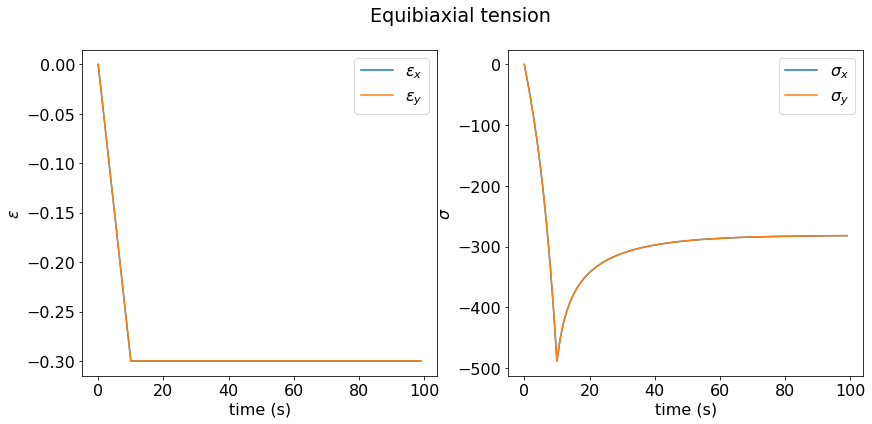

In [31]:
i = 0
time_hist = time_list[i]
eps_x_hist = eps_x_list[i]
eps_y_hist = eps_y_list[i]
sgm_x_hist = sgm_x_list[i]
sgm_y_hist = sgm_y_list[i]


fig,ax = plt.subplots(1,2,figsize=[14,6])

ax[0].plot(time_hist, eps_x_hist, label='$\epsilon_x$')
ax[0].plot(time_hist, eps_y_hist, label='$\epsilon_y$')
ax[0].legend()
ax[0].set(xlabel='time (s)', ylabel='$\epsilon$')

ax[1].plot(time_hist, sgm_x_hist, label='$\sigma_x$')
ax[1].plot(time_hist, sgm_y_hist, label='$\sigma_y$')
ax[1].legend()
ax[1].set(xlabel='time (s)', ylabel='$\sigma$')

fig.suptitle('Equibiaxial tension')
pass

In [32]:
time = np.vstack(time_list)
eps_x = np.vstack(eps_x_list)
eps_y = np.vstack(eps_y_list)
sgm_x = np.vstack(sgm_x_list)
sgm_y = np.vstack(sgm_y_list)
lmb_x = eps_x + 1.0
lmb_y = eps_y + 1.0
with open('training_data/gov_data.npy','wb') as f:
    np.save(f, [time, lmb_x, lmb_y, sgm_x, sgm_y])